In [1]:
!pip install "mlflow<3" scikit-learn xgboost matplotlib seaborn pandas numpy dagshub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [1]:
import os
import json
import tempfile
import pickle
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, train_test_split

from imblearn.over_sampling import KMeansSMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBClassifier

import mlflow
import dagshub
from mlflow.models import infer_signature

warnings.filterwarnings("ignore")

In [2]:
import os

os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/jayshah0726/diabetes_detection.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"] = "jayshah0726"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "7bdc38axxxxxxx"

mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

# ⭐ Set MLflow experiment name
mlflow.set_experiment("diabetes_detection")


<Experiment: artifact_location='mlflow-artifacts:/c17cde4163f64cc191d4af7f8b247e23', creation_time=1763725873680, experiment_id='1', last_update_time=1763725873680, lifecycle_stage='active', name='diabetes_detection', tags={}>

In [3]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

columns = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

df = pd.read_csv(url, names=columns)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



=== BASIC DESCRIPTIVE STATISTICS ===


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


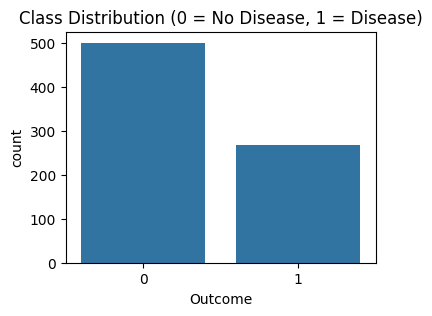


Class distribution (proportions):
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [4]:
print("\n=== BASIC DESCRIPTIVE STATISTICS ===")
display(df.describe())

plt.figure(figsize=(4,3))
sns.countplot(x=df["Outcome"])
plt.title("Class Distribution (0 = No Disease, 1 = Disease)")
plt.show()

class_counts = df["Outcome"].value_counts(normalize=True)
print("\nClass distribution (proportions):")
print(class_counts)

In [5]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric Columns:", numeric_cols)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_cols)


Numeric Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Categorical Columns: []


In [6]:
df["BMI_SkinThickness"] = df["BMI"] * df["SkinThickness"]
df["Age_DPF"] = df["Age"] * df["DiabetesPedigreeFunction"]
df["Glucose_BMI"] = df["Glucose"] * df["BMI"]

# 2) Ratio Features (Division)
df["Preg_Age_Ratio"] = df["Pregnancies"] / (df["Age"] + 1)

# 3) Useful Interaction: Glucose x Age
df["Glucose_Age"] = df["Glucose"] * df["Age"]

# 5) Log transforms (helps skewed features)
df["log_Insulin"] = np.log1p(df["Insulin"])
df["log_Glucose"] = np.log1p(df["Glucose"])

# 6) Risk Score Combining Multiple Attributes
df["Metabolic_Risk"] = (
    df["BMI"] * 0.3
    + df["Glucose"] * 0.4
    + df["Age"] * 0.2
    + df["DiabetesPedigreeFunction"] * 0.1
)

print("New engineered columns added:")
print([col for col in df.columns if col not in columns])

New engineered columns added:
['BMI_SkinThickness', 'Age_DPF', 'Glucose_BMI', 'Preg_Age_Ratio', 'Glucose_Age', 'log_Insulin', 'log_Glucose', 'Metabolic_Risk']


In [7]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
feature_names = X.columns.tolist()

# X_train, X_test, y_train, y_test = train_test_split(
#     X,
#     y,
#     test_size=0.3,
#     random_state=42,
#     stratify=y
# )

# print("\nShapes:")
# print("Train:", X_train.shape)
# print("Test :", X_test.shape)

# print("\nClass distribution:")
# print("Train:\n", y_train.value_counts(normalize=True))
# print("Test:\n", y_test.value_counts(normalize=True))

In [8]:
def prepare_training_data_with_rfe_smote(
    X_train_fold,
    y_train_fold,
    feature_names,
    n_features_to_select=15,
    random_state=42
):
    mlflow.sklearn.autolog(disable=True)
    # Defensive copies
    X_train_fold = X_train_fold.copy()
    y_train_fold = y_train_fold.copy()

    # 1. Scale BEFORE RFE (to match training used for RFE)
    scaler_rfe = StandardScaler()
    X_scaled_rfe = scaler_rfe.fit_transform(X_train_fold.values)

    # RFE on scaled-all features
    log_reg = LogisticRegression(max_iter=1500, solver="liblinear")
    rfe = RFE(estimator=log_reg, n_features_to_select=n_features_to_select)
    rfe.fit(X_scaled_rfe, y_train_fold.values)

    selected_features = list(np.array(feature_names)[rfe.support_].tolist())

    # 2. Select features from original X (unscaled) but then scale selected only
    X_sel = X_train_fold[selected_features].copy()
    scaler = StandardScaler()
    X_sel_scaled = scaler.fit_transform(X_sel.values)

    # 3. Check for NaNs/Infs
    if np.isnan(X_sel_scaled).any() or np.isinf(X_sel_scaled).any():
        raise ValueError("NaN or Inf present in selected features after scaling")

    # 4. KMeansSMOTE
    print("\n=== BEFORE KMeansSMOTE (TRAIN) ===")
    print(y_train_fold.value_counts())

    smote = KMeansSMOTE(
        sampling_strategy=1.0,
        k_neighbors=7,
        kmeans_estimator=8,
        cluster_balance_threshold="auto",
        density_exponent=2.0,
        n_jobs=-1,
        random_state=random_state
    )

    X_resampled, y_resampled = smote.fit_resample(X_sel_scaled, y_train_fold.values)

    # ensure dtypes and shapes
    X_resampled = np.asarray(X_resampled, dtype=float)
    y_resampled = np.asarray(y_resampled, dtype=int).ravel()

    print("\n=== AFTER KMeansSMOTE (TRAIN) ===")
    unique, counts = np.unique(y_resampled, return_counts=True)
    print(dict(zip(unique, counts)))

    mlflow.sklearn.autolog(disable=False)

    return X_resampled, y_resampled, selected_features, scaler

In [9]:
def Find_Optimal_Cutoff(target, predicted_prob):
    """Find optimal cutoff based on Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(target, predicted_prob)
    J = tpr - fpr
    ix = np.argmax(J)
    optimal_threshold = thresholds[ix]
    roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'threshold': thresholds})
    return float(optimal_threshold), roc_df

In [10]:
xgb_params = {
      "objective": "binary:logistic",
      "eval_metric": ["aucpr", "auc", "logloss"],
      "use_label_encoder": False,
      "tree_method": "hist",
      "max_depth": 16,
      "max_leaves": 2048,
      "grow_policy": "lossguide",
      "n_estimators": 6000,
      "learning_rate": 0.035,
      "subsample": 1.0,
      "colsample_bytree": 0.7,
      "colsample_bylevel": 0.7,
      "colsample_bynode": 0.7,
      "min_child_weight": 10,
      "gamma": 1.0,
      "reg_alpha": 0.0,
      "reg_lambda": 20.0,
      # "max_bin": 256,
      "random_state": 42,
      "n_jobs": -1,
  }

cleaned_params = {
        k: (",".join(v) if isinstance(v, list) else v)
        for k, v in xgb_params.items()
    }

In [14]:
n_splits = 5
random_state = 42
n_features_to_select = [8,10,12]

print("Starting Cross-Validation Run")

for n_feature in n_features_to_select:
  parent_run_name = f"diabetes_run_{pd.Timestamp.now():%Y%m%d_%H%M%S}"
  parent_run = mlflow.start_run(run_name=parent_run_name)

  mlflow.log_param("n_splits", n_splits)
  mlflow.set_tag("script", "cv_rfe_kmeanssmote_xgb")

  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

  fold_metrics = []
  fold_auc_val = []
  fold_thresholds = []
  fold_model_objects = []      # <— store model object in memory
  feature_names = X.columns.tolist()
  for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
      print(f"\n--------------- FOLD {fold} START ---------------")

      fold_name = f"fold_{fold}"
      with mlflow.start_run(run_name=fold_name, nested=True) as fold_run:

          # split
          X_train_fold = X.iloc[train_idx].reset_index(drop=True)
          y_train_fold = y.iloc[train_idx].reset_index(drop=True)
          X_val_fold = X.iloc[val_idx].reset_index(drop=True)
          y_val_fold = y.iloc[val_idx].reset_index(drop=True)

          print(f"[Fold {fold}] Shapes → Train: {X_train_fold.shape}, Val: {X_val_fold.shape}")

          # 1. RFE + SCALING + KMeansSMOTE
          print(f"[Fold {fold}] Running RFE + KMeansSMOTE…")

          X_train_res, y_train_res, selected_features, scaler = (
              prepare_training_data_with_rfe_smote(
                  X_train_fold=X_train_fold,
                  y_train_fold=y_train_fold,
                  feature_names=feature_names,
                  n_features_to_select=n_feature,
                  random_state=random_state
              )
          )

          print(f"[Fold {fold}] Selected Features ({len(selected_features)}): {selected_features}")

          mlflow.log_text("\n".join(selected_features),
                          artifact_file=f"fold_{fold}_selected_features.txt")
          mlflow.log_metric("n_selected_features", len(selected_features))

          # 2. Train Fold Model
          print(f"[Fold {fold}] Training XGBoost model…")

          xgb_params_fold = xgb_params.copy()

          mlflow.log_params({
              f"xgb_{k}": v for k, v in xgb_params_fold.items() if k != "eval_metric"
          })
          mlflow.log_text(str(xgb_params_fold.get("eval_metric")),
                          artifact_file=f"fold_{fold}_eval_metric.txt")

          model = XGBClassifier(
              objective="binary:logistic",
              eval_metric=["aucpr", "auc", "logloss"],
              use_label_encoder=False,
              tree_method="hist",
              max_depth=16,
              max_leaves=2048,
              grow_policy="lossguide",
              n_estimators=6000,
              learning_rate=0.035,
              subsample=1.0,
              colsample_bytree=0.7,
              colsample_bylevel=0.7,
              colsample_bynode=0.7,
              min_child_weight=10,
              gamma=1.0,
              reg_alpha=0.0,
              reg_lambda=20.0,
              # max_bin=256,
              random_state=42,
              n_jobs=-1,
          )
          model.fit(X_train_res, y_train_res)

          # 3. Compute Optimal Threshold on ORIGINAL TRAIN
          print(f"[Fold {fold}] Computing optimal threshold…")

          X_train_orig_sel = X_train_fold[selected_features].copy()
          X_train_orig_sel_scaled = scaler.transform(X_train_orig_sel)

          y_train_proba_raw = model.predict_proba(X_train_orig_sel_scaled)[:, 1]

          threshold_opt, roc_df_train = Find_Optimal_Cutoff(
              y_train_fold, y_train_proba_raw
          )

          print(f"[Fold {fold}] Optimal threshold = {threshold_opt:.4f}")
          fold_thresholds.append(threshold_opt)
          mlflow.log_metric("train_optimal_threshold", float(threshold_opt))

          # TRAIN METRICS
          y_train_pred_opt = (y_train_proba_raw >= threshold_opt).astype(int)
          train_acc = accuracy_score(y_train_fold, y_train_pred_opt)
          train_roc_auc = roc_auc_score(y_train_fold, y_train_proba_raw)
          train_precision = precision_score(y_train_fold, y_train_pred_opt, zero_division=0)
          train_recall = recall_score(y_train_fold, y_train_pred_opt, zero_division=0)
          cm_train = confusion_matrix(y_train_fold, y_train_pred_opt)

          if cm_train.size == 4:
              tn_tr, fp_tr, fn_tr, tp_tr = cm_train.ravel()
              train_specificity = tn_tr / (tn_tr + fp_tr) if (tn_tr + fp_tr) > 0 else 0.0
          else:
              train_specificity = 0.0

          mlflow.log_metric("train_accuracy", float(train_acc))
          mlflow.log_metric("train_roc_auc", float(train_roc_auc))
          mlflow.log_metric("train_precision", float(train_precision))
          mlflow.log_metric("train_recall", float(train_recall))
          mlflow.log_metric("train_specificity", float(train_specificity))

          print(f"[Fold {fold}] Train ROC-AUC = {train_roc_auc:.4f}")

          # 4. VALIDATION
          X_val_sel = X_val_fold[selected_features].copy()
          X_val_sel_scaled = scaler.transform(X_val_sel)

          y_val_proba = model.predict_proba(X_val_sel_scaled)[:, 1]
          y_val_pred_opt = (y_val_proba >= threshold_opt).astype(int)

          val_acc = accuracy_score(y_val_fold, y_val_pred_opt)
          val_roc_auc = roc_auc_score(y_val_fold, y_val_proba)
          val_precision = precision_score(y_val_fold, y_val_pred_opt, zero_division=0)
          val_recall = recall_score(y_val_fold, y_val_pred_opt, zero_division=0)
          cm_val = confusion_matrix(y_val_fold, y_val_pred_opt)

          if cm_val.size == 4:
              tn_v, fp_v, fn_v, tp_v = cm_val.ravel()
              val_specificity = tn_v / (tn_v + fp_v) if (tn_v + fp_v) > 0 else 0.0
          else:
              val_specificity = 0.0

          mlflow.log_metric("val_accuracy", float(val_acc))
          mlflow.log_metric("val_roc_auc", float(val_roc_auc))
          mlflow.log_metric("val_precision", float(val_precision))
          mlflow.log_metric("val_recall", float(val_recall))
          mlflow.log_metric("val_specificity", float(val_specificity))

          print(f"[Fold {fold}] Val ROC-AUC = {val_roc_auc:.4f}")

          fold_metrics.append({
              "fold": fold,
              "train_acc": float(train_acc),
              "train_roc_auc": float(train_roc_auc),
              "val_acc": float(val_acc),
              "val_roc_auc": float(val_roc_auc),
              "threshold": float(threshold_opt),
              "selected_features": selected_features
          })
          fold_auc_val.append(val_roc_auc)

          # Saving confusion matrix for each fold
          fig, ax = plt.subplots(figsize=(6, 4))
          sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", ax=ax)
          ax.set_title(f"Confusion Matrix - Fold {fold}")
          temp_png = f"confusion_matrix_fold_{fold}.png"
          fig.savefig(temp_png, dpi=120, bbox_inches="tight")
          mlflow.log_artifact(temp_png, artifact_path=f"fold_{fold}_plots")
          plt.close(fig)
          os.remove(temp_png)

          # Feature importance for each fold
          importance_df = pd.DataFrame({
              "feature": selected_features,
              "importance": model.feature_importances_
          })

          importance_csv_path = f"feature_importance_fold_{fold}.csv"
          importance_df.to_csv(importance_csv_path, index=False)
          mlflow.log_artifact(importance_csv_path, artifact_path=f"fold_{fold}_feature_importance")
          os.remove(importance_csv_path)


          fig, ax = plt.subplots(figsize=(6, 4))
          importance_df.sort_values("importance", ascending=False).plot(
              x="feature", y="importance", kind="bar", ax=ax, title=f"Feature Importance - Fold {fold}"
          )
          temp_imp_png = f"feature_importance_fold_{fold}.png"
          fig.savefig(temp_imp_png, dpi=120, bbox_inches="tight")
          mlflow.log_artifact(temp_imp_png, artifact_path=f"fold_{fold}_feature_importance")
          plt.close(fig)
          os.remove(temp_imp_png)

          # 5. Save fold model object in memory
          fold_model_objects.append((fold, model, val_roc_auc))

          # Also log file to MLflow
          temp_path = f"model_fold_{fold}.pkl"
          with open(temp_path, "wb") as f_out:
              pickle.dump(model, f_out)

          mlflow.log_artifact(temp_path, artifact_path=f"fold_{fold}_artifacts")
          os.remove(temp_path)

          print(f"--------------- FOLD {fold} END ---------------")

  # 6. SELECT BEST MODEL (from memory)
  print("Selecting Best Fold Model Based on ROC-AUC...")

  best_fold, best_model_obj, best_val_auc = sorted(
      fold_model_objects, key=lambda x: x[2], reverse=True
  )[0]

  print(f">>> Best Fold = {best_fold}  |  ROC-AUC = {best_val_auc:.4f}")

  best_sample_input = X.iloc[:5]  # small sample for signature
  best_sample_output = best_model_obj.predict_proba(best_sample_input[fold_metrics[best_fold]["selected_features"]])[:, 1]
  signature = infer_signature(best_sample_input, best_sample_output)

  mlflow.sklearn.log_model(
      sk_model=best_model_obj,
      artifact_path="best_model",
      registered_model_name="best_model_xgb_diabetes",
      signature=signature
  )

  print(f"Best model successfully registered with infer signature for n_features:{n_feature}!")


  # 7. FINAL AVG METRICS
  avg_val_auc = np.mean(fold_auc_val)
  print(f"\nMean CV ROC-AUC = {avg_val_auc:.4f}")
  mlflow.log_metric("cv_mean_val_roc_auc", float(avg_val_auc))

  print("\n=================================")
  print("CV Training & MLflow Logging DONE")
  print("Parent run id:", parent_run.info.run_id)
  print("=================================\n")
  mlflow.end_run()

Starting Cross-Validation Run

--------------- FOLD 0 START ---------------
[Fold 0] Shapes → Train: (614, 16), Val: (154, 16)
[Fold 0] Running RFE + KMeansSMOTE…

=== BEFORE KMeansSMOTE (TRAIN) ===
Outcome
0    400
1    214
Name: count, dtype: int64

=== AFTER KMeansSMOTE (TRAIN) ===
{np.int64(0): np.int64(400), np.int64(1): np.int64(402)}
[Fold 0] Selected Features (8): ['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Preg_Age_Ratio', 'Glucose_Age', 'log_Glucose', 'Metabolic_Risk']
[Fold 0] Training XGBoost model…
[Fold 0] Computing optimal threshold…
[Fold 0] Optimal threshold = 0.3671
[Fold 0] Train ROC-AUC = 0.8706
[Fold 0] Val ROC-AUC = 0.8524
--------------- FOLD 0 END ---------------
🏃 View run fold_0 at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1/runs/7a2ff044a2984a0aa6e3616b9362759c
🧪 View experiment at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1

--------------- FOLD 1 START ---------------
[Fold 1] Shapes →

Registered model 'best_model_xgb_diabetes' already exists. Creating a new version of this model...
2025/11/21 15:46:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_xgb_diabetes, version 7
Created version '7' of model 'best_model_xgb_diabetes'.


Best model successfully registered with infer signature for n_features:8!

Mean CV ROC-AUC = 0.8335

CV Training & MLflow Logging DONE
Parent run id: 3753dc6f28b44b619469b1a817191305

🏃 View run diabetes_run_20251121_154427 at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1/runs/3753dc6f28b44b619469b1a817191305
🧪 View experiment at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1

--------------- FOLD 0 START ---------------
[Fold 0] Shapes → Train: (614, 16), Val: (154, 16)
[Fold 0] Running RFE + KMeansSMOTE…

=== BEFORE KMeansSMOTE (TRAIN) ===
Outcome
0    400
1    214
Name: count, dtype: int64

=== AFTER KMeansSMOTE (TRAIN) ===
{np.int64(0): np.int64(400), np.int64(1): np.int64(403)}
[Fold 0] Selected Features (10): ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_BMI', 'Preg_Age_Ratio', 'Glucose_Age', 'log_Glucose', 'Metabolic_Risk']
[Fold 0] Training XGBoost model…
[Fold 0] Computing optimal thresh

Registered model 'best_model_xgb_diabetes' already exists. Creating a new version of this model...
2025/11/21 15:48:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_xgb_diabetes, version 8
Created version '8' of model 'best_model_xgb_diabetes'.


Best model successfully registered with infer signature for n_features:10!

Mean CV ROC-AUC = 0.8357

CV Training & MLflow Logging DONE
Parent run id: e9b8f8bdbbe4497aad541cb64deb2137

🏃 View run diabetes_run_20251121_154627 at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1/runs/e9b8f8bdbbe4497aad541cb64deb2137
🧪 View experiment at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1

--------------- FOLD 0 START ---------------
[Fold 0] Shapes → Train: (614, 16), Val: (154, 16)
[Fold 0] Running RFE + KMeansSMOTE…

=== BEFORE KMeansSMOTE (TRAIN) ===
Outcome
0    400
1    214
Name: count, dtype: int64

=== AFTER KMeansSMOTE (TRAIN) ===
{np.int64(0): np.int64(400), np.int64(1): np.int64(401)}
[Fold 0] Selected Features (12): ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Age_DPF', 'Glucose_BMI', 'Preg_Age_Ratio', 'Glucose_Age', 'log_Insulin', 'log_Glucose', 'Metabolic_Risk']
[Fold 0] Training XGBoost model…
[Fold 

Registered model 'best_model_xgb_diabetes' already exists. Creating a new version of this model...
2025/11/21 15:50:46 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: best_model_xgb_diabetes, version 9
Created version '9' of model 'best_model_xgb_diabetes'.


Best model successfully registered with infer signature for n_features:12!

Mean CV ROC-AUC = 0.8303

CV Training & MLflow Logging DONE
Parent run id: 6667e1b4e1604441a7ce57b6375f0e34

🏃 View run diabetes_run_20251121_154838 at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1/runs/6667e1b4e1604441a7ce57b6375f0e34
🧪 View experiment at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1


In [13]:
 mlflow.end_run()

🏃 View run diabetes_run_20251121_154231 at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1/runs/3faff12956dd4ea3974170810c61b4de
🧪 View experiment at: https://dagshub.com/jayshah0726/diabetes_detection.mlflow/#/experiments/1
